# all model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Load the new dataset
file_path = 'modeltraining.csv'  # Replace with your file path
df_new = pd.read_csv(file_path)

# Encode the target variable ('relative sentiments') into numeric format
label_encoder = LabelEncoder()
df_new['relative sentiments'] = label_encoder.fit_transform(df_new['relative sentiments'])

# Extract features (X) and target (y)
X_new = df_new.drop(columns=['Unnamed: 0', 'review_cleaned', 'relative sentiments'], errors='ignore')  # Features
y_new = df_new['relative sentiments']  # Target variable

# Identify categorical columns
categorical_columns = X_new.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_columns}")

# Split the dataset into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

# preprocessing pipeline for categorical columns (OneHotEncoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)  # Apply OneHotEncoder to categorical columns
    ],
    remainder='passthrough'
)

# pipeline with preprocessing and RandomForest model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),  # preprocessing to categorical columns
    ('classifier', RandomForestClassifier(random_state=42))  # Classifier
])

# grid search for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1],
    'classifier__bootstrap': [True]
}

{'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}

# Initialize grid search
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the training data
grid_search_rf.fit(X_train_new, y_train_new)

# Output best parameters and performance
print("Best Hyperparameters for Random Forest on new dataset:", grid_search_rf.best_params_)

# Evaluate the model
best_rf_new = grid_search_rf.best_estimator_

y_train_pred_rf = best_rf_new.predict(X_train_new)
train_accuracy_rf = accuracy_score(y_train_new, y_train_pred_rf)
y_test_pred_rf = best_rf_new.predict(X_test_new)
test_accuracy_rf = accuracy_score(y_test_new, y_test_pred_rf)

print("\nTuned Random Forest Model Accuracy (Training): {:.2f}%".format(train_accuracy_rf * 100))
print("Tuned Random Forest Model Accuracy (Testing): {:.2f}%".format(test_accuracy_rf * 100))


# Naive Bayes

Training set size: (29356, 5000)
Testing set size: (12582, 5000)
Cross-Validation Accuracy Scores: [0.73772055 0.76800191 0.77277062 0.76916657 0.7555741 ]
Mean Cross-Validation Accuracy: 76.06%

Test Accuracy: 76.61%

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.64      0.68      2840
     neutral       0.97      0.21      0.35      1785
    positive       0.77      0.94      0.84      7957

    accuracy                           0.77     12582
   macro avg       0.82      0.60      0.63     12582
weighted avg       0.79      0.77      0.74     12582


Confusion Matrix:


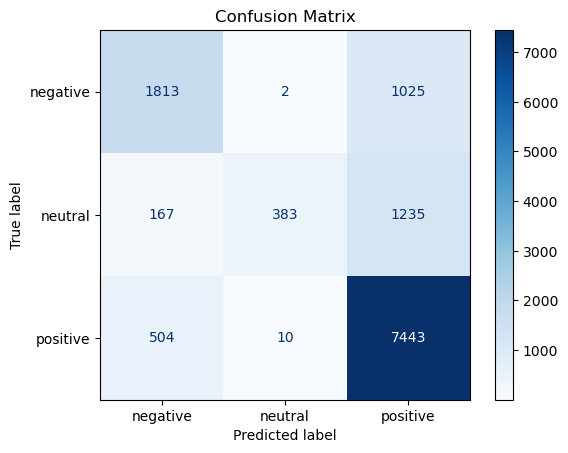

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'data_pp_lda_sentiment.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Convert 'review_cleaned' to a format suitable for vectorization (e.g., lists of strings to space-separated strings)
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: ' '.join(eval(x)))

# Vectorize the cleaned reviews using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['review_cleaned'])  # Features
y = df['relative sentiments']  # Target variable: positive, neutral, negative

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Initialize Naive Bayes classifier
nb_model = MultinomialNB()

# Perform cross-validation
cv_scores = cross_val_score(nb_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Train the model
nb_model.fit(X_train, y_train)

# Predict sentiments on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=nb_model.classes_)

# Plot confusion matrix
print("\nConfusion Matrix:")
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [26]:
import pickle

# Save Naive Bayes model
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(nb_model, model_file)

# Save TF-IDF vectorizer
with open('nb_tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

In [ ]:
# Load the saved model and vectorizer
with open('model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

# Predict sentiment for new reviews
#new_reviews = ["This car is amazing with great performance!", "The car had too many issues and was unreliable."]
#new_reviews = ["car is bad ","The car has average features and is okay for its price", "car is good"]
new_reviews = ["My 2023 Alpina B8, is hands down the best car I have ever owned. 5 stars doesn't do it justice from the exterior to the interior, from the front bumper to the rear spoiler, from the moon-sunroof to the underside, all perfection", "The car has average features and is okay for its price", "Trunk gaskets wrong design, leaking rain water inside, Car goes toasted."]
new_reviews_vectorized = loaded_vectorizer.transform(new_reviews)
predicted_sentiments = loaded_model.predict(new_reviews_vectorized)

print(predicted_sentiments)


# Random Forest

Training set size: (29356, 5000)
Testing set size: (12582, 5000)
Cross-Validation Accuracy Scores: [0.9195279  0.92572723 0.94873629 0.97543818 0.96744962]
Mean Cross-Validation Accuracy: 94.74%

Test Accuracy: 93.67%

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.83      0.88      2840
     neutral       0.92      1.00      0.96      1785
    positive       0.94      0.96      0.95      7957

    accuracy                           0.94     12582
   macro avg       0.93      0.93      0.93     12582
weighted avg       0.94      0.94      0.94     12582


Confusion Matrix:


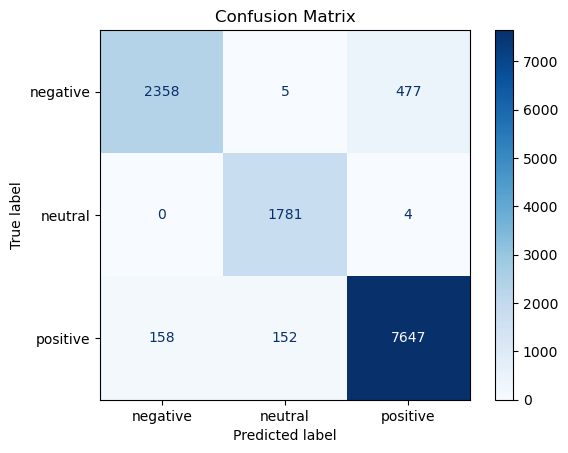

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'data_pp_lda_sentiment.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Convert 'review_cleaned' to a format suitable for vectorization (e.g., lists of strings to space-separated strings)
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: ' '.join(eval(x)))

# Vectorize the cleaned reviews using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['review_cleaned'])  # Features
y = df['relative sentiments']  # Target variable: positive, neutral, negative

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Train the model
rf_model.fit(X_train, y_train)

# Predict sentiments on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)

# Plot confusion matrix
print("\nConfusion Matrix:")
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Support Vector Machine

Training set size: (29356, 5000)
Testing set size: (12582, 5000)
Cross-Validation Accuracy Scores: [0.8191464  0.82486886 0.85944206 0.86812925 0.84487898]
Mean Cross-Validation Accuracy: 84.33%

Test Accuracy: 87.55%

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      2840
     neutral       0.83      0.89      0.86      1785
    positive       0.91      0.91      0.91      7957

    accuracy                           0.88     12582
   macro avg       0.85      0.86      0.85     12582
weighted avg       0.88      0.88      0.88     12582


Confusion Matrix:


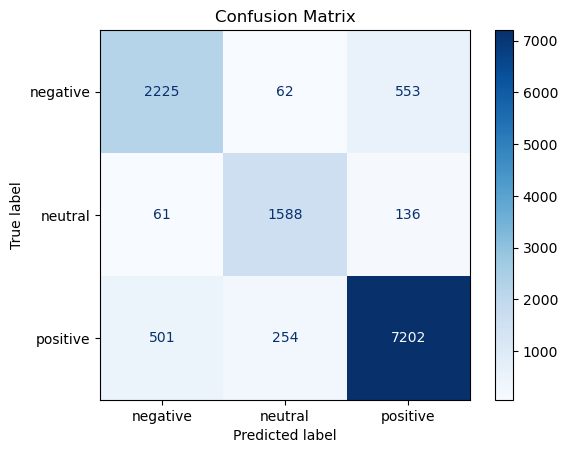

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'data_pp_lda_sentiment.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Convert 'review_cleaned' to a format suitable for vectorization (e.g., lists of strings to space-separated strings)
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: ' '.join(eval(x)))

# Vectorize the cleaned reviews using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['review_cleaned'])  # Features
y = df['relative sentiments']  # Target variable: positive, neutral, negative

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Initialize SVM classifier
svm_model = SVC(kernel='linear', random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Train the model
svm_model.fit(X_train, y_train)

# Predict sentiments on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svm_model.classes_)

# Plot confusion matrix
print("\nConfusion Matrix:")
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [22]:
with open('svm_model.pkl', 'rb') as svm_file:
    svm_model = pickle.load(svm_file)

with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    tfidf_vectorizer = pickle.load(vectorizer_file)

# Predict on new reviews
new_reviews = ["car is bad"," The car has average features and is okay for its price", "car is good"]
#new_reviews = ["My 2023 Alpina B8, is hands down the best car I have ever owned. 5 stars doesn't do it justice from the exterior to the interior, from the front bumper to the rear spoiler, from the moon-sunroof to the underside, all perfection", "The car has average features and is okay for its price", "Trunk gaskets wrong design, leaking rain water inside, Car goes toasted."]
new_reviews_vectorized = tfidf_vectorizer.transform(new_reviews)

svm_predictions = svm_model.predict(new_reviews_vectorized)
print(f"SVM Predictions: {svm_predictions}")


SVM Predictions: ['negative' 'negative' 'positive']
